## DengAI competition
The goal of this competition is to build a model that predicts the number of Dengue cases in San Juan and Iquitos

In this notebook we look how to fix some missing values and detecting outliers:
- [X] missing values
- [X] outliers
- [X] Replace week 53 with week 0

### Import libraries

In [1]:
import pandas as pd
import os
import seaborn as sns
from dateutil import parser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
import numpy as np

### Load data

In [2]:
data_folder = 'data'
features_train_path = 'dengue_features_train.csv'
labels_train_path = 'dengue_labels_train.csv'
features_test_path = 'dengue_features_test.csv'

In [3]:
features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
features_test = pd.read_csv(os.path.join(data_folder, features_test_path))

### Basic Pre-processing

In [4]:
# transform week_start_date into a datetime feature
features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)

  0%|          | 0/1456 [00:00<?, ?it/s]

In [5]:
# Merge features and labels for easier exploration
train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])

### Print dataframes

In [6]:
train_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [7]:
features_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


### Columns

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9   reanalysis_air_temp_k                  1446 non-null   float64 

In [9]:
train_df.iloc[train_df[train_df.ndvi_ne.isna()].index + 1]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
6,sj,1990,24,1990-06-11,0.112900,0.092800,0.205071,0.210271,3.48,299.207143,...,82.000000,3.48,17.234286,2.042857,27.414286,6.771429,32.2,23.3,29.7,4
10,sj,1990,28,1990-07-09,0.192875,0.082350,0.191943,0.152929,22.27,299.512857,...,81.467143,22.27,17.418571,2.157143,27.557143,7.157143,31.7,21.7,63.7,8
14,sj,1990,32,1990-08-06,NaN,0.064333,0.164443,0.138857,28.80,300.391429,...,79.650000,28.80,17.950000,2.328571,28.200000,7.557143,33.3,23.3,11.4,23
15,sj,1990,33,1990-08-13,NaN,0.128033,0.206957,0.168243,90.75,299.958571,...,84.178571,90.75,18.515714,1.857143,28.042857,6.685714,32.8,22.8,44.7,13
16,sj,1990,34,1990-08-20,0.190233,0.168800,0.167657,0.172286,32.40,300.332857,...,80.947143,32.40,18.174286,2.485714,28.342857,7.014286,33.3,23.3,5.4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,sj,2008,6,2008-02-05,-0.111700,-0.003200,0.232843,0.271171,0.00,297.237143,...,70.642857,0.00,13.225714,2.071429,24.214286,5.157143,27.2,21.1,35.9,2
928,sj,2008,10,2008-03-04,-0.088900,-0.090033,0.223243,0.154186,0.00,297.878571,...,74.681429,0.00,14.474286,2.614286,25.114286,6.114286,29.4,21.1,13.0,1
1019,iq,2002,6,2002-02-05,0.184917,0.173329,0.168743,0.184429,4.68,295.912857,...,96.641429,4.68,16.722857,5.185714,26.625000,9.725000,34.0,20.8,70.4,14
1171,iq,2005,1,2005-01-08,0.314843,0.186629,0.303300,0.270400,70.60,298.162857,...,93.005714,70.60,18.370000,9.757143,28.500000,9.100000,33.2,23.0,74.9,10


In [12]:
def fill_ma(df, col):
    df[col+'_MA'] =  df[col].fillna(df[col].mean()).rolling(2).mean().tolist()
    df[col] = df.apply(lambda x: x[col] if not np.isnan(x[col]) else x[col+'_MA'], axis=1)
    df.drop(columns=[col+'_MA'], inplace=True)

In [13]:
# fill_ma_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm']
fill_ma_cols = [col for col in train_df.columns if train_df[train_df[col].isna()].shape[0] > 0]
for col in tqdm(fill_ma_cols):
    fill_ma(train_df, col)

  0%|          | 0/20 [00:00<?, ?it/s]

ndvi_ne


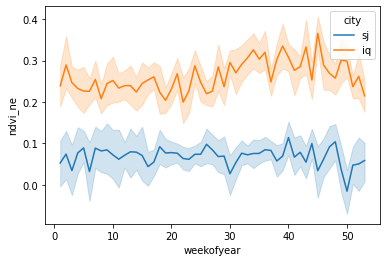

ndvi_nw


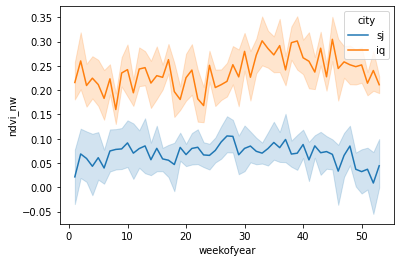

ndvi_se


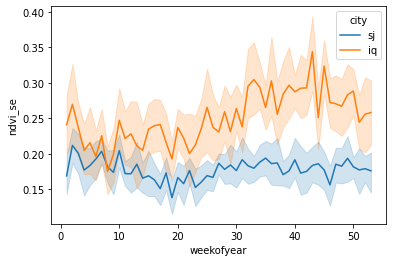

ndvi_sw


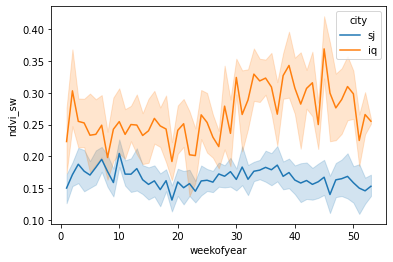

precipitation_amt_mm


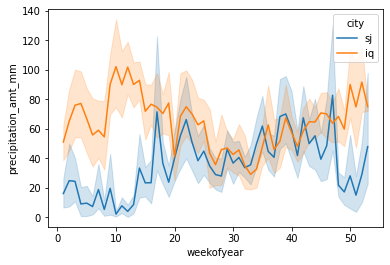

reanalysis_air_temp_k


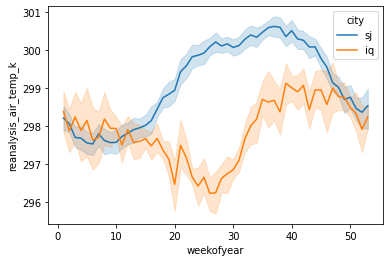

reanalysis_avg_temp_k


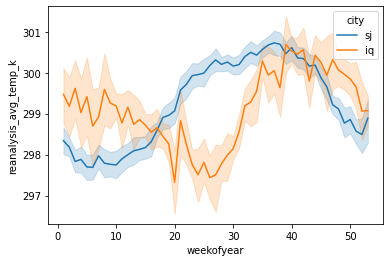

reanalysis_dew_point_temp_k


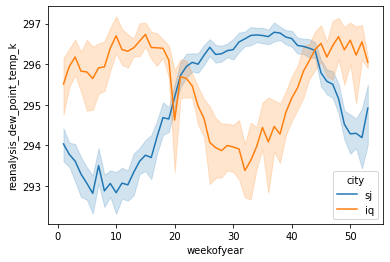

reanalysis_max_air_temp_k


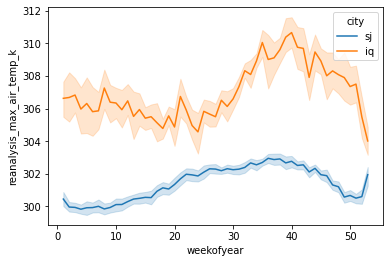

reanalysis_min_air_temp_k


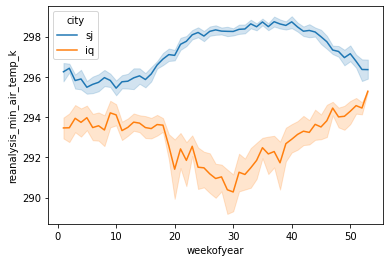

reanalysis_precip_amt_kg_per_m2


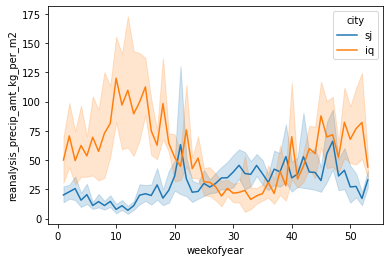

reanalysis_relative_humidity_percent


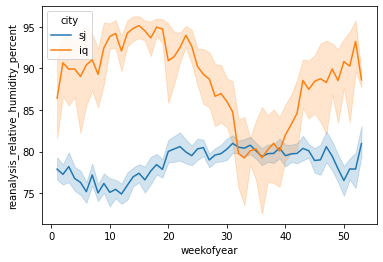

reanalysis_sat_precip_amt_mm


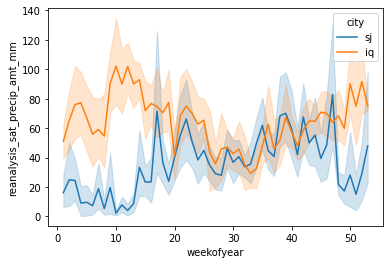

reanalysis_specific_humidity_g_per_kg


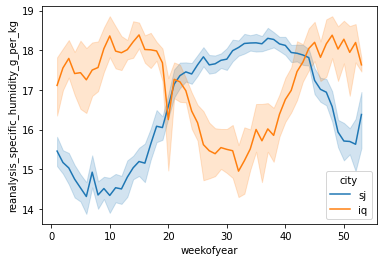

reanalysis_tdtr_k


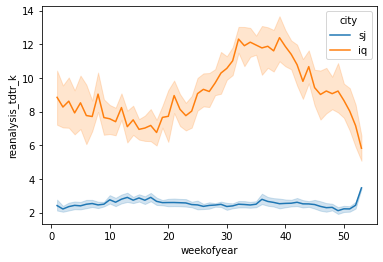

station_avg_temp_c


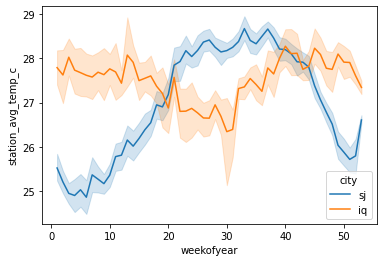

station_diur_temp_rng_c


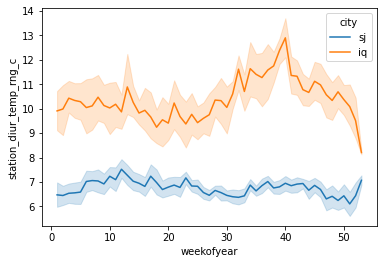

station_max_temp_c


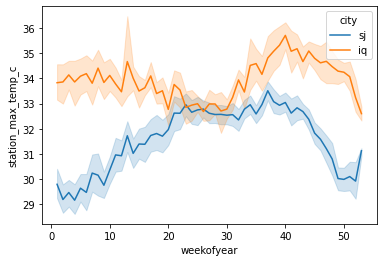

station_min_temp_c


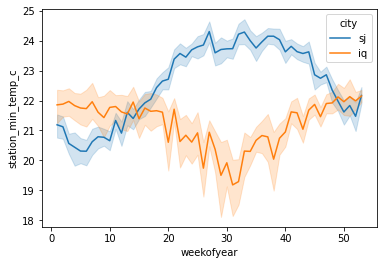

station_precip_mm


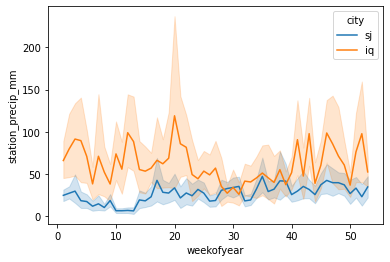

total_cases


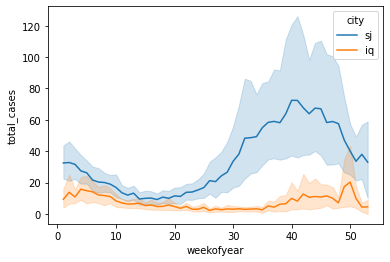

ndvi_ne_MA


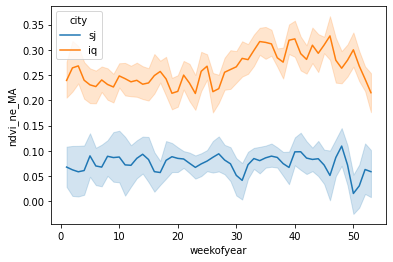

ndvi_nw_MA


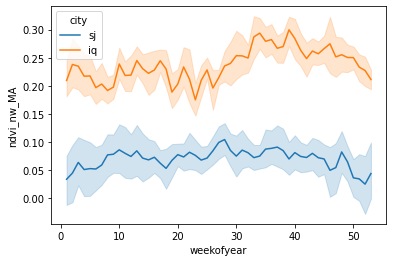

ndvi_se_MA


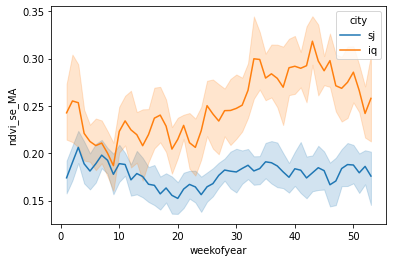

ndvi_sw_MA


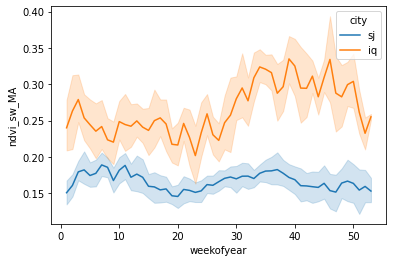

In [14]:
for column in train_df.columns:
    if column not in ['city', 'weekofyear', 'year', 'week_start_date']:
        print(column)
        sns.lineplot(x='weekofyear', y=column, hue='city', data= train_df)
        plt.show()

### Outliers

In [15]:
train_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,ndvi_ne_MA,ndvi_nw_MA,ndvi_se_MA,ndvi_sw_MA
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1455.000000,1455.000000,1455.000000,1455.000000
mean,2001.031593,26.503434,0.138109,0.129571,0.203678,0.202188,45.755091,298.699909,299.223530,295.245901,...,27.184471,8.071337,32.449266,22.101006,39.272813,24.675137,0.142247,0.130527,0.203761,0.202275
std,5.408314,15.019437,0.132476,0.118241,0.073402,0.083347,43.576588,1.358786,1.258700,1.523796,...,1.274704,2.103044,1.948824,1.567135,47.160777,43.596000,0.116613,0.107116,0.060119,0.070480
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000,-0.222350,-0.244600,0.063358,-0.042971
25%,1997.000000,13.750000,0.050750,0.050425,0.155470,0.144621,9.960000,297.659643,298.257143,294.119643,...,26.328571,6.528571,31.100000,21.100000,8.850000,5.000000,0.059182,0.053781,0.161450,0.153629
50%,2002.000000,26.500000,0.124622,0.120643,0.196550,0.190121,38.390000,298.646429,299.285714,295.635000,...,27.400000,7.364286,32.800000,22.200000,24.150000,12.000000,0.127147,0.122950,0.196073,0.189600
75%,2005.000000,39.250000,0.230950,0.212725,0.247461,0.246775,70.227500,299.827500,300.207143,296.456071,...,28.128571,9.550000,33.900000,23.300000,53.600000,28.000000,0.233366,0.216173,0.238546,0.243254
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000,0.424279,0.387569,0.463821,0.495208


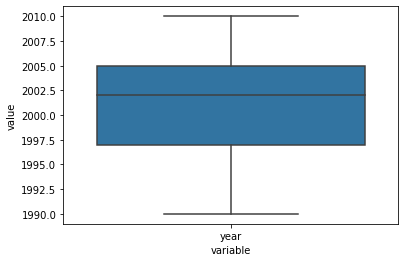

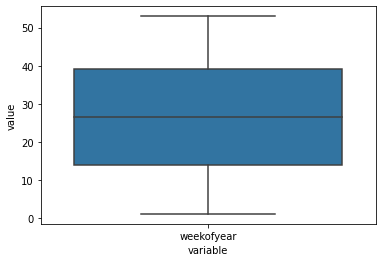

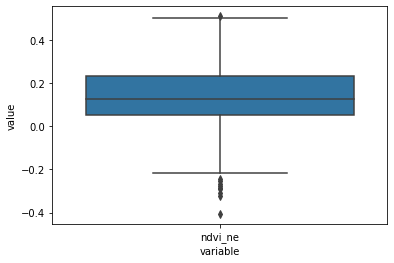

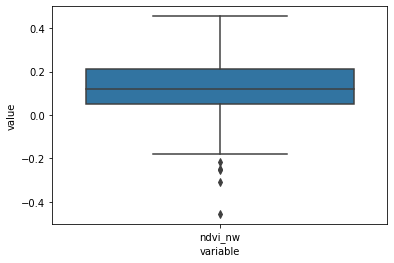

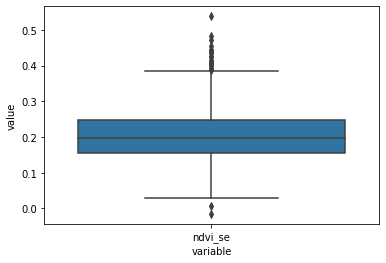

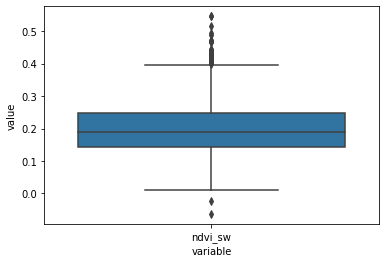

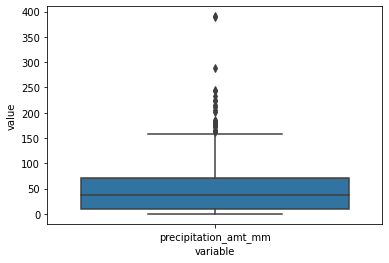

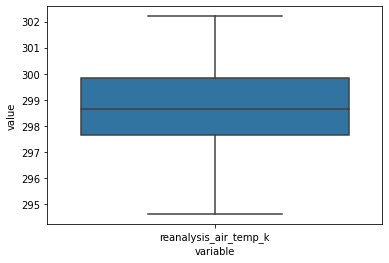

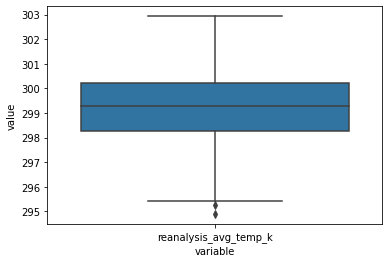

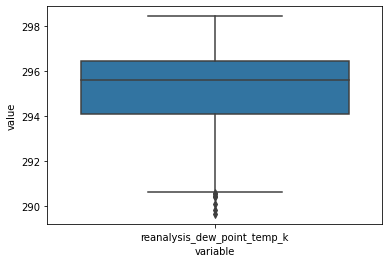

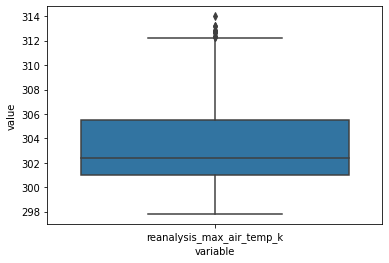

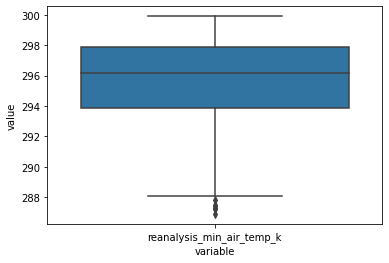

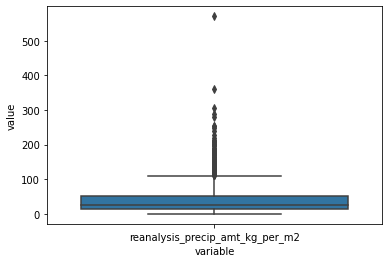

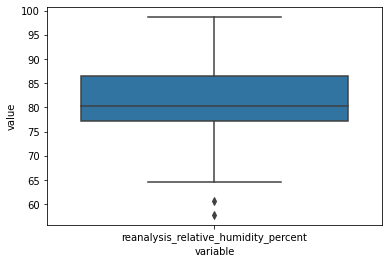

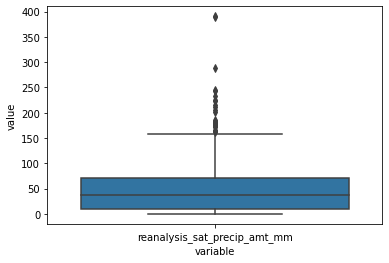

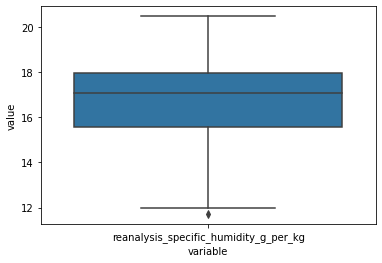

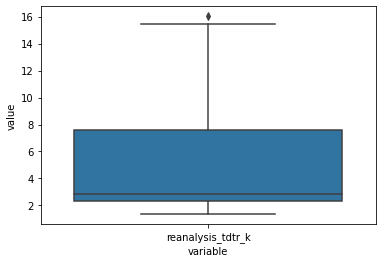

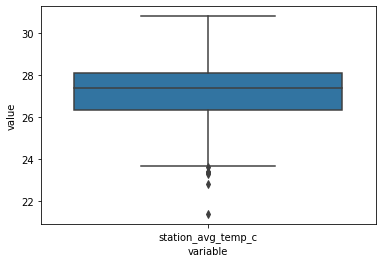

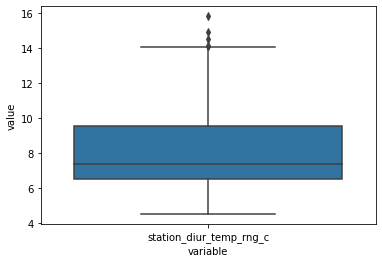

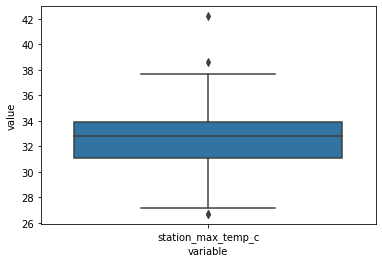

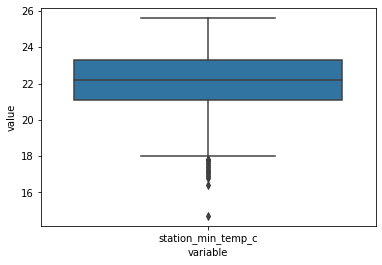

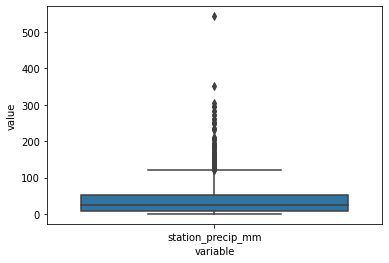

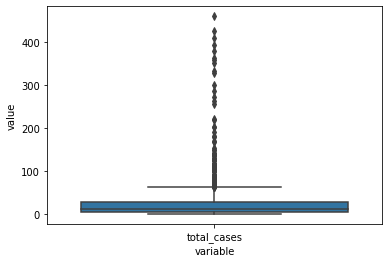

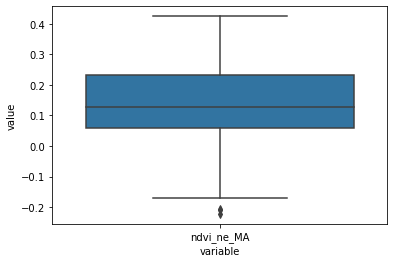

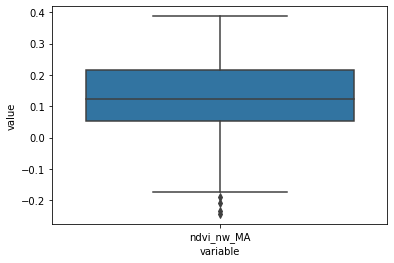

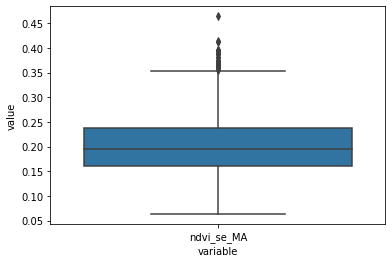

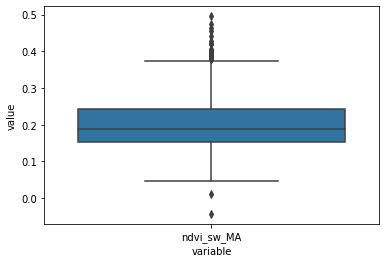

In [16]:
for col in train_df.select_dtypes(include=np.number).columns:
    #print(train_df[col].dtype.is)
    sns.boxplot(x="variable", y="value", data=pd.melt(train_df[[col]]))
    plt.show()

In [18]:
train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)

### Conclusions
* Since all features are numeric time series, moving averages was used to fill the missing values
* Big outliers seem to happen in precipitation, which might be correct data but might hurt the model, this should be revisited